In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
root = "/kaggle/input"
for item in os.listdir(root):
    print(item)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

solesensei_bdd100k


In [2]:
base_path = "/kaggle/input/solesensei_bdd100k"
print(os.listdir(base_path))

['bdd100k_labels_release', 'bdd100k_seg', 'bdd100k']


In [3]:
for folder in os.listdir(base_path):
    print(folder, "->", os.listdir(os.path.join(base_path, folder))[:5])

bdd100k_labels_release -> ['bdd100k']
bdd100k_seg -> ['bdd100k']
bdd100k -> ['bdd100k']


# **Data Preparation**

## 1- Check for Missing or Corrupted Images

In [4]:
import cv2

image_dir = "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train"

missing_or_broken = []

for img_file in os.listdir(image_dir):
    path = os.path.join(image_dir, img_file)
    img = cv2.imread(path)
    if img is None:
        missing_or_broken.append(img_file)

print("Total broken/missing images:", len(missing_or_broken))
print("Examples:", missing_or_broken[:10])

Total broken/missing images: 4
Examples: ['testB', 'testA', 'trainB', 'trainA']


## 2- Check Labels for Missing Fields

In [5]:
import json

label_path = "/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json"

with open(label_path, "r") as f:
    labels = json.load(f)

print("Total label entries:", len(labels))
print("First entry example:\n", labels[0])


Total label entries: 69863
First entry example:
 {'name': '0000f77c-6257be58.jpg', 'attributes': {'weather': 'clear', 'scene': 'city street', 'timeofday': 'daytime'}, 'timestamp': 10000, 'labels': [{'category': 'traffic light', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'green'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 1125.902264, 'y1': 133.184488, 'x2': 1156.978645, 'y2': 210.875445}, 'id': 0}, {'category': 'traffic light', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'green'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 1156.978645, 'y1': 136.637417, 'x2': 1191.50796, 'y2': 210.875443}, 'id': 1}, {'category': 'traffic sign', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 1101.731743, 'y1': 211.122087, 'x2': 1170.79037, 'y2': 233.566141}, 'id': 2}, {'category': 'traffic sign', 'attri

In [6]:
clean_labels = []
invalid_boxes = []

for lbl in labels:
    img_name = lbl["name"]
    valid_objs = []

    for obj in lbl.get("labels", []):
        # Only process objects with bounding boxes
        if "box2d" in obj and obj.get("category", "") != "":
            x1, y1, x2, y2 = obj["box2d"].values()
            
            if x1 < x2 and y1 < y2:
                valid_objs.append({
                    "category": obj["category"],
                    "box2d": obj["box2d"]
                })
            else:
                invalid_boxes.append((img_name, obj))

    if len(valid_objs) > 0:
        clean_labels.append({
            "name": img_name,
            "labels": valid_objs
        })

print("Original entries:", len(labels))
print("After cleaning:", len(clean_labels))
print("Invalid boxes:", len(invalid_boxes))


Original entries: 69863
After cleaning: 69863
Invalid boxes: 0


## 3- Flattening JSON → DataFrame

In [7]:
import pandas as pd

# Convert clean_labels to DataFrame
rows = []
for lbl in clean_labels:
    img = lbl["name"]
    for obj in lbl["labels"]:
        x1, y1, x2, y2 = obj["box2d"].values()
        rows.append([img, obj["category"], x1, y1, x2, y2])

df = pd.DataFrame(rows, columns=["image", "category", "x1", "y1", "x2", "y2"])

print("Total annotations:", len(df))

# check duplicate rows
dup_annots = df.duplicated().sum()
print("Duplicate annotations:", dup_annots)

# check duplicate images
dup_imgs = df["image"].duplicated().sum()
print("Duplicate image names:", dup_imgs)

Total annotations: 1286871
Duplicate annotations: 1
Duplicate image names: 1217008


## 4- Handling Duplicates

In [8]:
# Drop exact duplicate annotation rows
df_cleaned = df.drop_duplicates()

print("After removing exact duplicates:", len(df_cleaned))

After removing exact duplicates: 1286870


## 5- Handling Outliers

In [9]:
# Compute width & height
df_cleaned["width"] = df_cleaned["x2"] - df_cleaned["x1"]
df_cleaned["height"] = df_cleaned["y2"] - df_cleaned["y1"]

# Filter out invalid or extreme boxes
df_cleaned = df_cleaned[
    (df_cleaned["width"] > 1) & 
    (df_cleaned["height"] > 1) & 
    (df_cleaned["width"] < 2000) & 
    (df_cleaned["height"] < 2000)
]

print("After removing outliers:", len(df_cleaned))

After removing outliers: 1286782


/tmp/ipykernel_36/2976052580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["width"] = df_cleaned["x2"] - df_cleaned["x1"]
/tmp/ipykernel_36/2976052580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["height"] = df_cleaned["y2"] - df_cleaned["y1"]


# **EDA and Feature Engineering**

## 1- Dataset Stats & Quality Check

In [10]:
df_cleaned.head()

,image,category,x1,y1,x2,y2,width,height
0,0000f77c-6257be58.jpg,traffic light,1125.902264,133.184488,1156.978645,210.875445,31.076381,77.690957
1,0000f77c-6257be58.jpg,traffic light,1156.978645,136.637417,1191.507960,210.875443,34.529315,74.238026
2,0000f77c-6257be58.jpg,traffic sign,1101.731743,211.122087,1170.790370,233.566141,69.058627,22.444054
3,0000f77c-6257be58.jpg,traffic sign,0.000000,0.246631,100.381647,122.825696,100.381647,122.579065
4,0000f77c-6257be58.jpg,car,45.240919,254.530367,357.805838,487.906215,312.564919,233.375848


In [11]:
print("🔹 Dataset Overview 🔹")
print("Total annotations:", len(df_cleaned))
print("Unique images:", df_cleaned["image"].nunique())
print("Unique categories:", df_cleaned["category"].nunique())
print("Categories:", df_cleaned["category"].unique())

# Objects per image
objs_per_img = df_cleaned.groupby("image").size()
print("\n📌 Objects per image (summary):")
print(objs_per_img.describe())

# Objects per category
objs_per_cat = df_cleaned["category"].value_counts()
print("\n📌 Objects per category:")
print(objs_per_cat)

# Bounding box statistics
print("\n📌 Bounding Box Size Stats (width/height in pixels):")
pd.set_option("display.float_format", "{:.2f}".format)
print(df_cleaned[["width", "height"]].describe())

🔹 Dataset Overview 🔹
Total annotations: 1286782
Unique images: 69863
Unique categories: 10
Categories: ['traffic light' 'traffic sign' 'car' 'person' 'bus' 'truck' 'rider'
 'bike' 'motor' 'train']

📌 Objects per image (summary):
count    69863.000000
mean        18.418648
std          9.618313
min          3.000000
25%         11.000000
50%         17.000000
75%         24.000000
max         91.000000
dtype: float64

📌 Objects per category:
category
car              713165
traffic sign     239674
traffic light    186098
person            91341
truck             29969
bus               11672
bike               7209
rider              4516
motor              3002
train               136
Name: count, dtype: int64

📌 Bounding Box Size Stats (width/height in pixels):
           width     height
count 1286782.00 1286782.00
mean       56.60      49.92
std        75.69      61.69
min         1.02       1.02
25%        16.87      17.14
50%        28.70      29.09
75%        60.41      55.28
max

## 2- Visualizations (Object Categories & Counts)

**Import Libraries and Setup**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from pathlib import Path

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
print(f"DataFrame shape: {df_cleaned.shape}")
print(f"Columns: {list(df_cleaned.columns)}")

✅ Libraries imported successfully!
DataFrame shape: (1286782, 8)
Columns: ['image', 'category', 'x1', 'y1', 'x2', 'y2', 'width', 'height']


**Data Overview and Basic Statistics**

In [13]:
# Basic dataset information
print("📊 DATASET OVERVIEW:")
print("=" * 50)
print(f"Total objects: {len(df_cleaned):,}")
print(f"Unique images: {df_cleaned['image'].nunique():,}")
print(f"Unique categories: {df_cleaned['category'].nunique()}")
print(f"Average objects per image: {len(df_cleaned) / df_cleaned['image'].nunique():.2f}")

# Category counts
category_counts = df_cleaned['category'].value_counts()
print(f"\n🏷️ TOP 10 CATEGORIES:")
for i, (category, count) in enumerate(category_counts.head(10).items(), 1):
    percentage = (count / len(df_cleaned)) * 100
    print(f"{i:2d}. {category:<15} {count:>8,} ({percentage:5.1f}%)")

# Basic bbox statistics
print(f"\n📦 BOUNDING BOX STATISTICS:")
print(f"Width  - Mean: {df_cleaned['width'].mean():.1f}, Std: {df_cleaned['width'].std():.1f}")
print(f"Height - Mean: {df_cleaned['height'].mean():.1f}, Std: {df_cleaned['height'].std():.1f}")
print(f"Area   - Mean: {(df_cleaned['width'] * df_cleaned['height']).mean():.1f}")


📊 DATASET OVERVIEW:
Total objects: 1,286,782
Unique images: 69,863
Unique categories: 10
Average objects per image: 18.42

🏷️ TOP 10 CATEGORIES:
 1. car              713,165 ( 55.4%)
 2. traffic sign     239,674 ( 18.6%)
 3. traffic light    186,098 ( 14.5%)
 4. person            91,341 (  7.1%)
 5. truck             29,969 (  2.3%)
 6. bus               11,672 (  0.9%)
 7. bike               7,209 (  0.6%)
 8. rider              4,516 (  0.4%)
 9. motor              3,002 (  0.2%)
10. train                136 (  0.0%)

📦 BOUNDING BOX STATISTICS:
Width  - Mean: 56.6, Std: 75.7
Height - Mean: 49.9, Std: 61.7
Area   - Mean: 6777.0


**Class Distribution Visualization**

In [14]:
def plot_class_distribution(df, top_n=12):
    category_counts = df['category'].value_counts()
    top_categories = category_counts.head(top_n)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot
    bars = ax1.bar(range(len(top_categories)), top_categories.values, 
                   color=sns.color_palette("viridis", len(top_categories)))
    ax1.set_xticks(range(len(top_categories)))
    ax1.set_xticklabels(top_categories.index, rotation=45, ha='right')
    ax1.set_title(f"Top {top_n} Object Categories Distribution", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Count")
    ax1.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, top_categories.values):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.01,
                f'{count:,}', ha='center', va='bottom', fontsize=9)
    
    # Pie chart for top 8
    top_8 = top_categories.head(8)
    others_count = category_counts.sum() - top_8.sum()
    
    pie_data = top_8.copy()
    if others_count > 0:
        pie_data['Others'] = others_count
    
    wedges, texts, autotexts = ax2.pie(pie_data.values, labels=pie_data.index, 
                                      autopct='%1.1f%%', startangle=90)
    ax2.set_title("Category Distribution (Top 8 + Others)", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return category_counts

**Generate class distribution plot**

🎨 Generating Class Distribution Plot...


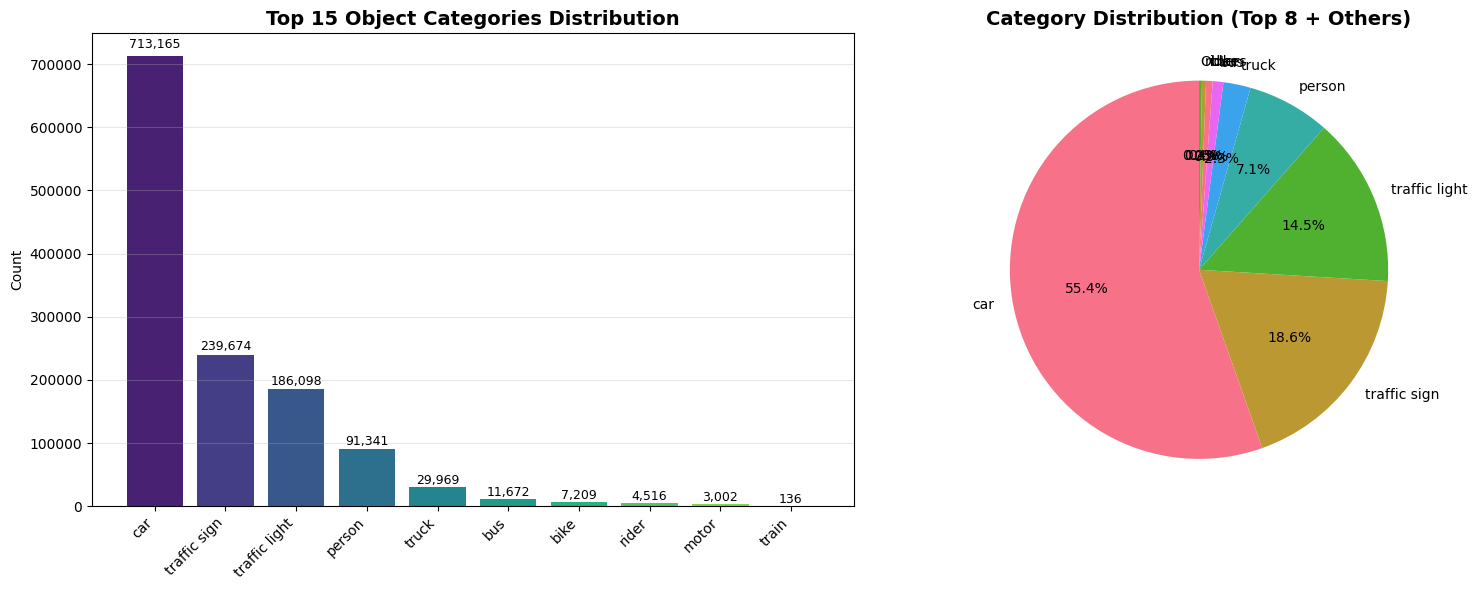

In [15]:
print("🎨 Generating Class Distribution Plot...")
category_stats = plot_class_distribution(df_cleaned, top_n=15)

**Objects per Image Distribution**

In [16]:
def plot_objects_per_image(df):
    # Calculate objects per image
    objects_per_image = df.groupby('image').size()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram
    ax1.hist(objects_per_image, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title("Objects per Image Distribution", fontweight='bold')
    ax1.set_xlabel("Number of Objects")
    ax1.set_ylabel("Frequency")
    ax1.grid(axis='y', alpha=0.3)
    
    # Box plot
    bp = ax2.boxplot(objects_per_image, patch_artist=True, 
                     boxprops=dict(facecolor='lightgreen', alpha=0.7))
    ax2.set_title("Objects per Image\n(Box Plot)", fontweight='bold')
    ax2.set_ylabel("Number of Objects")
    ax2.grid(axis='y', alpha=0.3)
    
    # Bar plot of most common counts
    count_freq = objects_per_image.value_counts().head(10)
    ax3.bar(count_freq.index, count_freq.values, color='coral', alpha=0.7)
    ax3.set_title("Most Common Object Counts", fontweight='bold')
    ax3.set_xlabel("Objects per Image")
    ax3.set_ylabel("Number of Images")
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    stats = {
        'Total Images': len(objects_per_image),
        'Mean': objects_per_image.mean(),
        'Median': objects_per_image.median(),
        'Std': objects_per_image.std(),
        'Min': objects_per_image.min(),
        'Max': objects_per_image.max()
    }
    
    print("📈 OBJECTS PER IMAGE STATISTICS:")
    for key, value in stats.items():
        if key == 'Total Images':
            print(f"   • {key}: {value:,}")
        else:
            print(f"   • {key}: {value:.2f}")
    
    return objects_per_image

**Generate objects per image analysis**


🎨 Generating Objects per Image Analysis...


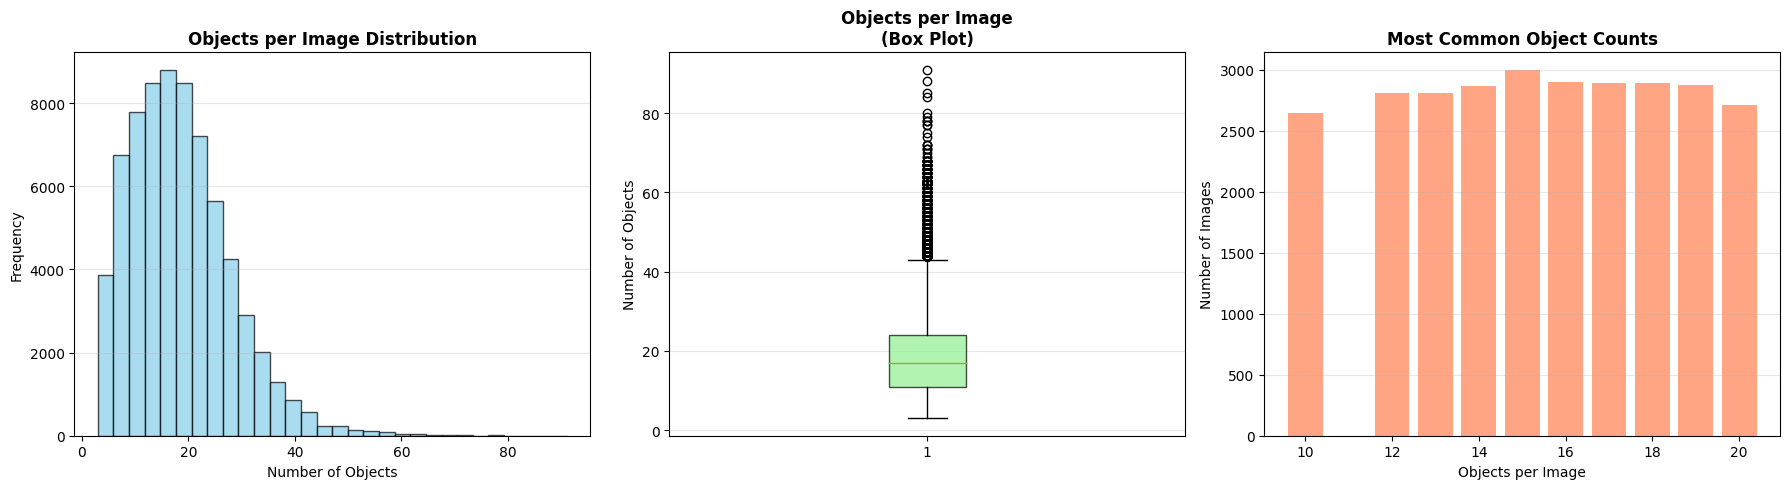

📈 OBJECTS PER IMAGE STATISTICS:
   • Total Images: 69,863
   • Mean: 18.42
   • Median: 17.00
   • Std: 9.62
   • Min: 3.00
   • Max: 91.00


In [17]:
print("\n🎨 Generating Objects per Image Analysis...")
obj_per_img_stats = plot_objects_per_image(df_cleaned)

**Bounding Box Size Analysis**

In [18]:
def plot_bbox_analysis(df):
    # Calculate additional metrics
    df_copy = df.copy()
    df_copy['area'] = df_copy['width'] * df_copy['height']
    df_copy['aspect_ratio'] = df_copy['width'] / df_copy['height']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # 1. Width histogram
    axes[0].hist(df_copy['width'], bins=50, alpha=0.7, color='coral', edgecolor='black')
    axes[0].set_title("Bounding Box Widths", fontweight='bold')
    axes[0].set_xlabel("Width (pixels)")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Height histogram
    axes[1].hist(df_copy['height'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    axes[1].set_title("Bounding Box Heights", fontweight='bold')
    axes[1].set_xlabel("Height (pixels)")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(axis='y', alpha=0.3)
    
    # 3. Area histogram (log scale for better visualization)
    axes[2].hist(df_copy['area'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[2].set_title("Bounding Box Areas", fontweight='bold')
    axes[2].set_xlabel("Area (pixels²)")
    axes[2].set_ylabel("Frequency")
    axes[2].set_yscale('log')
    axes[2].grid(axis='y', alpha=0.3)
    
    # 4. Aspect ratio histogram (filter extreme values)
    filtered_ratios = df_copy[(df_copy['aspect_ratio'] >= 0.1) & (df_copy['aspect_ratio'] <= 10)]['aspect_ratio']
    axes[3].hist(filtered_ratios, bins=50, alpha=0.7, color='gold', edgecolor='black')
    axes[3].set_title("Aspect Ratios (0.1 ≤ ratio ≤ 10)", fontweight='bold')
    axes[3].set_xlabel("Aspect Ratio (width/height)")
    axes[3].set_ylabel("Frequency")
    axes[3].grid(axis='y', alpha=0.3)
    
    # 5. Width vs Height scatter (sample for performance)
    sample_size = min(10000, len(df_copy))
    sample_df = df_copy.sample(n=sample_size)
    axes[4].scatter(sample_df['width'], sample_df['height'], alpha=0.6, s=1, color='purple')
    axes[4].set_title(f"Width vs Height Scatter\n(Sample of {sample_size:,})", fontweight='bold')
    axes[4].set_xlabel("Width (pixels)")
    axes[4].set_ylabel("Height (pixels)")
    axes[4].grid(alpha=0.3)
    
    # 6. Box plot by top categories
    top_5_categories = df_copy['category'].value_counts().head(5).index
    category_areas = [df_copy[df_copy['category'] == cat]['area'].values for cat in top_5_categories]
    
    bp = axes[5].boxplot(category_areas, labels=top_5_categories, patch_artist=True)
    axes[5].set_title("Area Distribution by Category\n(Top 5 Categories)", fontweight='bold')
    axes[5].set_xlabel("Category")
    axes[5].set_ylabel("Area (pixels²)")
    axes[5].set_yscale('log')
    axes[5].tick_params(axis='x', rotation=45)
    axes[5].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("📦 DETAILED BOUNDING BOX STATISTICS:")
    print(f"   • Total bounding boxes: {len(df_copy):,}")
    
    metrics = ['width', 'height', 'area', 'aspect_ratio']
    for metric in metrics:
        if metric in df_copy.columns:
            data = df_copy[metric]
            if metric == 'aspect_ratio':
                data = data[(data >= 0.1) & (data <= 10)]  # Filter extremes
            print(f"   • {metric.replace('_', ' ').title()}:")
            print(f"     - Mean: {data.mean():.2f}, Std: {data.std():.2f}")
            print(f"     - Min: {data.min():.2f}, Max: {data.max():.2f}")

**Generate bounding box analysis**


🎨 Generating Bounding Box Analysis...


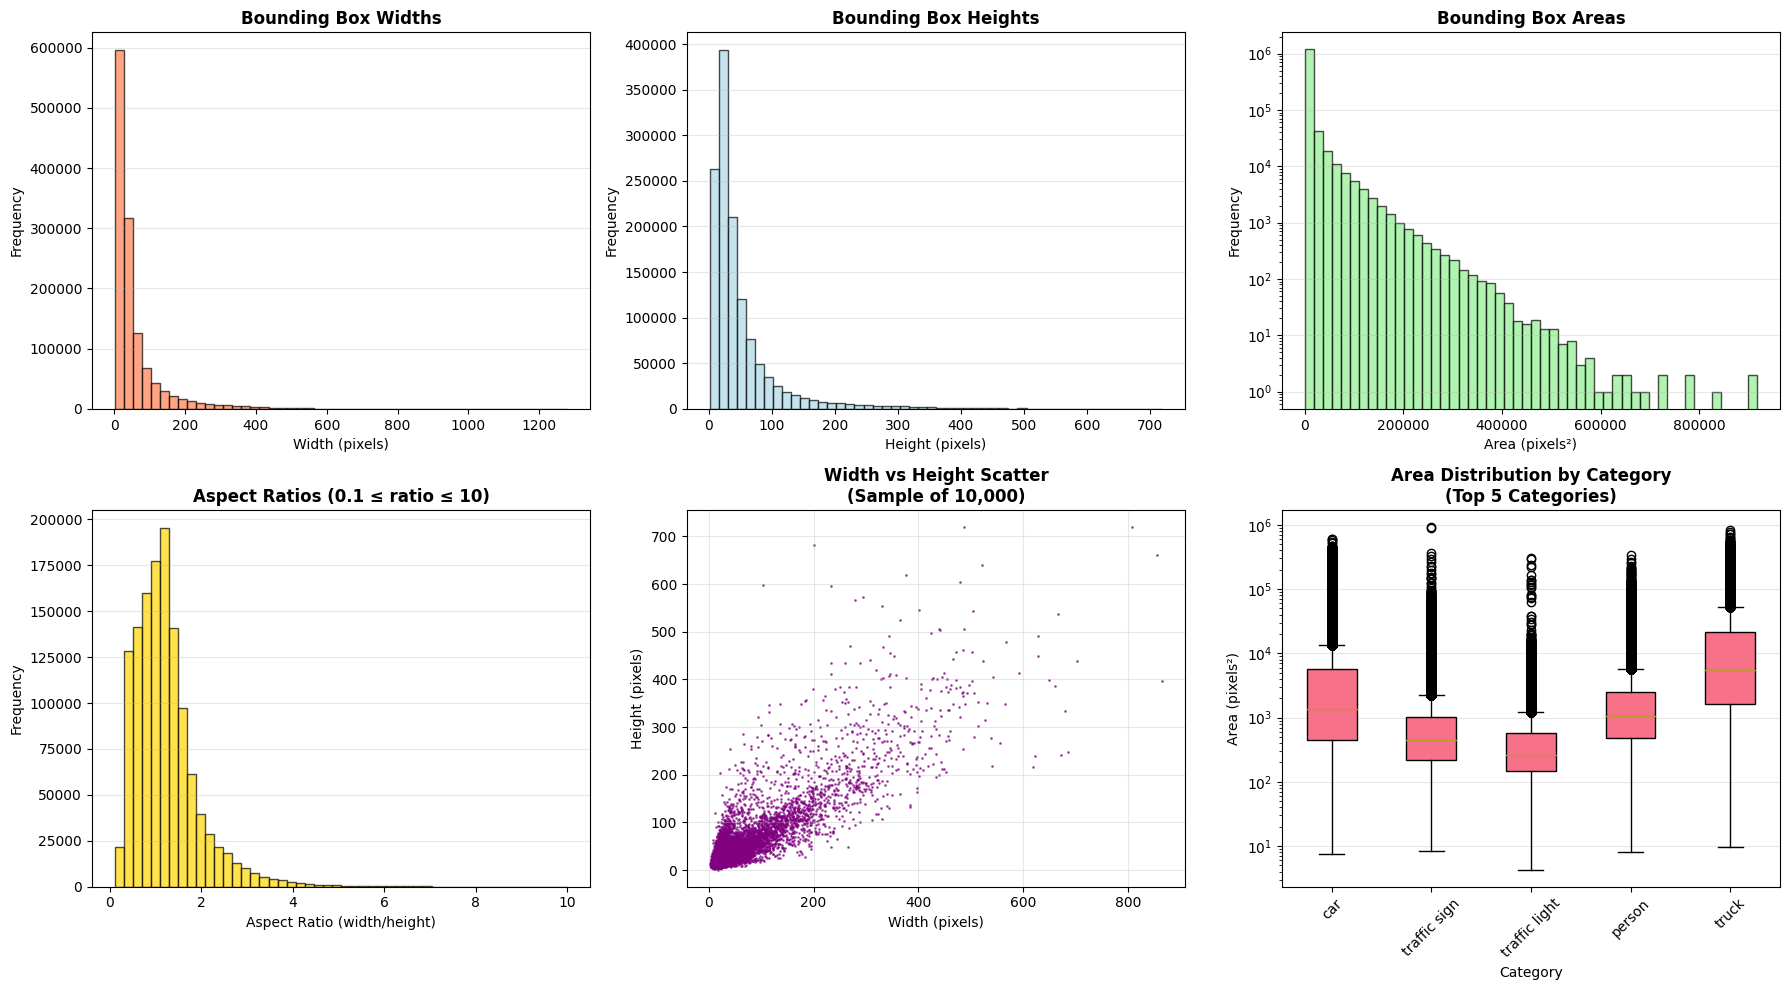

📦 DETAILED BOUNDING BOX STATISTICS:
   • Total bounding boxes: 1,286,782
   • Width:
     - Mean: 56.60, Std: 75.69
     - Min: 1.02, Max: 1279.27
   • Height:
     - Mean: 49.92, Std: 61.69
     - Min: 1.02, Max: 719.77
   • Area:
     - Mean: 6777.03, Std: 22850.98
     - Min: 4.31, Max: 917709.77
   • Aspect Ratio:
     - Mean: 1.21, Std: 0.72
     - Min: 0.10, Max: 10.00


In [19]:
print("\n🎨 Generating Bounding Box Analysis...")
plot_bbox_analysis(df_cleaned)

**Summary Report**

In [20]:
print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total Images: {df_cleaned['image'].nunique():,}")
print(f"   • Total Objects: {len(df_cleaned):,}")
print(f"   • Unique Categories: {df_cleaned['category'].nunique()}")
print(f"   • Avg Objects/Image: {len(df_cleaned) / df_cleaned['image'].nunique():.2f}")

print(f"\n🏆 TOP 5 CATEGORIES:")
top_5 = df_cleaned['category'].value_counts().head(5)
for i, (cat, count) in enumerate(top_5.items(), 1):
    pct = (count / len(df_cleaned)) * 100
    print(f"   {i}. {cat}: {count:,} ({pct:.1f}%)")

print(f"\n📦 BOUNDING BOX SUMMARY:")
print(f"   • Width: {df_cleaned['width'].mean():.0f} ± {df_cleaned['width'].std():.0f} pixels")
print(f"   • Height: {df_cleaned['height'].mean():.0f} ± {df_cleaned['height'].std():.0f} pixels")
area_mean = (df_cleaned['width'] * df_cleaned['height']).mean()
area_std = (df_cleaned['width'] * df_cleaned['height']).std()
print(f"   • Area: {area_mean:.0f} ± {area_std:.0f} pixels²")



📊 DATASET OVERVIEW:
   • Total Images: 69,863
   • Total Objects: 1,286,782
   • Unique Categories: 10
   • Avg Objects/Image: 18.42

🏆 TOP 5 CATEGORIES:
   1. car: 713,165 (55.4%)
   2. traffic sign: 239,674 (18.6%)
   3. traffic light: 186,098 (14.5%)
   4. person: 91,341 (7.1%)
   5. truck: 29,969 (2.3%)

📦 BOUNDING BOX SUMMARY:
   • Width: 57 ± 76 pixels
   • Height: 50 ± 62 pixels
   • Area: 6777 ± 22851 pixels²


##   3- Category vs Object

In [21]:
# Area column
df_cleaned["area"] = df_cleaned["width"] * df_cleaned["height"]

# Group by category
size_stats = df_cleaned.groupby("category")[["width", "height", "area"]].mean().sort_values("area")

print(size_stats)

               width  height     area
category                             
traffic light  15.87   25.29   507.42
traffic sign   32.28   25.20  1198.99
person         27.67   66.71  2945.27
bike           60.63   67.38  5926.20
rider          43.51   82.55  6315.62
motor          67.12   68.28  7584.09
car            74.62   58.02  9423.08
truck         127.59  115.13 27772.88
bus           145.66  127.38 35806.86
train         267.08   83.87 38624.72


In [22]:
box_stats = df_cleaned.groupby("category")[["width", "height", "area"]].describe()
print(box_stats.head())

             width                                                  height  \
             count   mean    std  min   25%   50%    75%     max     count   
category                                                                     
bike       7209.00  60.63  48.17 4.39 27.65 47.41  77.94  523.78   7209.00   
bus       11672.00 145.66 142.91 1.50 47.12 92.31 190.81 1196.64  11672.00   
car      713165.00  74.62  86.43 1.05 22.47 41.46  89.06 1278.60 713165.00   
motor      3002.00  67.12  62.79 4.49 26.22 47.91  86.81  773.63   3002.00   
person    91341.00  27.67  23.80 1.10 14.67 21.21  32.40  842.83  91341.00   

                 ...                    area                                  \
           mean  ...    75%    max     count     mean      std   min     25%   
category         ...                                                           
bike      67.38  ...  82.96 563.26   7209.00  5926.20 10685.23 32.80 1015.32   
bus      127.38  ... 147.16 719.33  11672.00 35806.86 7

In [23]:
counts = df_cleaned["category"].value_counts()
print(counts)

category
car              713165
traffic sign     239674
traffic light    186098
person            91341
truck             29969
bus               11672
bike               7209
rider              4516
motor              3002
train               136
Name: count, dtype: int64


## 4 -Attributes vs Objects

In [24]:
BDD100K_LABELS_PATH = '/kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json'

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")
print(f"BDD100K Labels Path: {BDD100K_LABELS_PATH}")

Libraries imported successfully!
BDD100K Labels Path: /kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json


In [25]:
# Load BDD100K labels
print(f"Loading BDD100K labels from: {BDD100K_LABELS_PATH}")

try:
    with open(BDD100K_LABELS_PATH, 'r') as f:
        bdd_data = json.load(f)
    print(f"✅ Successfully loaded {len(bdd_data)} images.")
except FileNotFoundError:
    print(f"❌ Error: BDD100K labels file not found at {BDD100K_LABELS_PATH}")
    print("Please check if:")
    print("1. You've added the BDD100K dataset to your Kaggle notebook")
    print("2. The file path is correct")
    # Let's check what's actually in the input directory
    print("\nLet's see what's available:")
    !ls /kaggle/input/
except Exception as e:
    print(f"❌ Error loading file: {e}")

Loading BDD100K labels from: /kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json
✅ Successfully loaded 69863 images.


In [26]:
# Flatten the data: Create a DataFrame where each row is an object instance
print("🔄 Processing and flattening the data...")

all_objects_data = []

for image_info in bdd_data:
    image_name = image_info['name']
    attributes = image_info['attributes']
    timeofday = attributes.get('timeofday', 'unknown')
    weather = attributes.get('weather', 'unknown')
    scene = attributes.get('scene', 'unknown')

    # Process labels if they exist
    if 'labels' in image_info:
        for label in image_info['labels']:
            # Only include objects with bounding boxes (actual detectable objects)
            if 'category' in label and 'box2d' in label:
                obj_category = label['category']
                
                all_objects_data.append({
                    'image_name': image_name,
                    'timeofday': timeofday,
                    'weather': weather,
                    'scene': scene,
                    'category': obj_category,
                    'bbox_x1': label['box2d']['x1'],
                    'bbox_y1': label['box2d']['y1'],
                    'bbox_x2': label['box2d']['x2'],
                    'bbox_y2': label['box2d']['y2']
                })

# Create DataFrame
df_objects = pd.DataFrame(all_objects_data)
print(f"📊 Total object instances after flattening: {len(df_objects)}")

# Show basic info about the data
print("\n📋 DataFrame Info:")
print(df_objects.head())
print(f"\n🔍 Unique object categories found: {len(df_objects['category'].unique())}")
print(df_objects['category'].value_counts())

🔄 Processing and flattening the data...
📊 Total object instances after flattening: 1286871

📋 DataFrame Info:
              image_name timeofday weather        scene       category  \
0  0000f77c-6257be58.jpg   daytime   clear  city street  traffic light   
1  0000f77c-6257be58.jpg   daytime   clear  city street  traffic light   
2  0000f77c-6257be58.jpg   daytime   clear  city street   traffic sign   
3  0000f77c-6257be58.jpg   daytime   clear  city street   traffic sign   
4  0000f77c-6257be58.jpg   daytime   clear  city street            car   

   bbox_x1  bbox_y1  bbox_x2  bbox_y2  
0  1125.90   133.18  1156.98   210.88  
1  1156.98   136.64  1191.51   210.88  
2  1101.73   211.12  1170.79   233.57  
3     0.00     0.25   100.38   122.83  
4    45.24   254.53   357.81   487.91  

🔍 Unique object categories found: 10
category
car              713211
traffic sign     239686
traffic light    186117
person            91349
truck             29971
bus               11672
bike          

In [27]:
# Filter to relevant object detection categories
relevant_categories = [
    'car', 'pedestrian', 'traffic light', 'traffic sign', 'truck', 'bus',
    'motorcycle', 'bicycle', 'rider', 'train'
]

print("🎯 Filtering to relevant object categories...")
print(f"Categories to keep: {relevant_categories}")

df_objects_filtered = df_objects[df_objects['category'].isin(relevant_categories)].copy()

print(f"\n📈 Statistics after filtering:")
print(f"  - Total object instances: {len(df_objects_filtered)}")
print(f"  - Unique categories: {len(df_objects_filtered['category'].unique())}")
print(f"  - Categories present: {list(df_objects_filtered['category'].unique())}")

print(f"\n📊 Object category distribution:")
print(df_objects_filtered['category'].value_counts())

print(f"\n🌅 Time of day distribution:")
print(df_objects_filtered['timeofday'].value_counts())

print(f"\n🌤️ Weather distribution:")
print(df_objects_filtered['weather'].value_counts())

print(f"\n🏙️ Scene type distribution:")
print(df_objects_filtered['scene'].value_counts())

🎯 Filtering to relevant object categories...
Categories to keep: ['car', 'pedestrian', 'traffic light', 'traffic sign', 'truck', 'bus', 'motorcycle', 'bicycle', 'rider', 'train']

📈 Statistics after filtering:
  - Total object instances: 1185310
  - Unique categories: 7
  - Categories present: ['traffic light', 'traffic sign', 'car', 'bus', 'truck', 'rider', 'train']

📊 Object category distribution:
category
car              713211
traffic sign     239686
traffic light    186117
truck             29971
bus               11672
rider              4517
train               136
Name: count, dtype: int64

🌅 Time of day distribution:
timeofday
daytime      657255
night        437226
dawn/dusk     89804
undefined      1025
Name: count, dtype: int64

🌤️ Weather distribution:
weather
clear            614933
overcast         168901
undefined        135612
snowy             91048
partly cloudy     90015
rainy             82990
foggy              1811
Name: count, dtype: int64

🏙️ Scene type distri

In [28]:
print(df_objects_filtered['category'].value_counts())

category
car              713211
traffic sign     239686
traffic light    186117
truck             29971
bus               11672
rider              4517
train               136
Name: count, dtype: int64


In [29]:
relevant_categories = [
    'car', 'pedestrian', 'traffic light', 'traffic sign', 'truck', 'bus',
    'motorcycle', 'bicycle', 'rider', 'train'
]

🌅 === ANALYSIS 1: TIME OF DAY vs OBJECTS ===

📊 Object counts by time of day:
category    bus     car  rider  traffic light  traffic sign  train  truck
timeofday                                                                
dawn/dusk  1014   55985    316          12937         17251      9   2292
daytime    8410  401271   3331          88866        132955     97  22325
night      2227  255152    868          84260         89366     30   5323
undefined    21     803      2             54           114      0     31


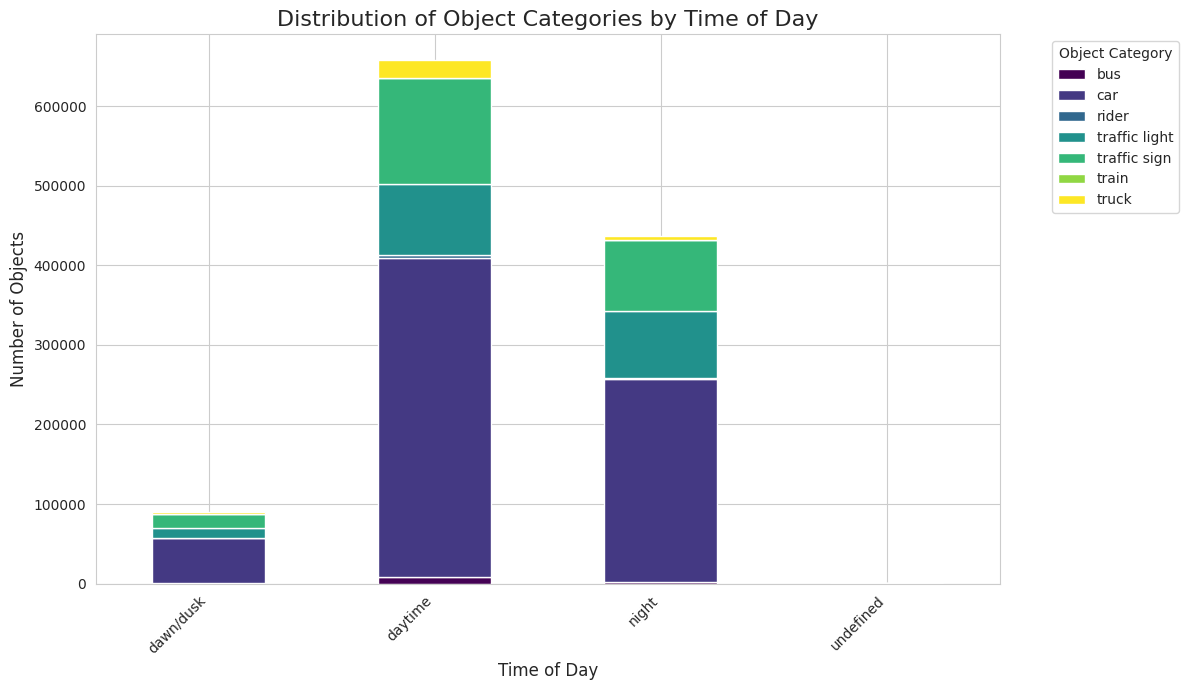


🚶 Pedestrian counts by time of day:
Series([], dtype: int64)


In [30]:
print("🌅 === ANALYSIS 1: TIME OF DAY vs OBJECTS ===")

# Group by time of day and category
timeofday_counts = df_objects_filtered.groupby(['timeofday', 'category']).size().unstack(fill_value=0)
print("\n📊 Object counts by time of day:")
print(timeofday_counts)

# Visualization 1: Stacked bar chart
plt.figure(figsize=(12, 7))
# Ensure there's data to plot for the stacked bar chart, otherwise it might also error for all categories
if not timeofday_counts.empty:
    timeofday_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
    plt.title('Distribution of Object Categories by Time of Day', fontsize=16)
    plt.ylabel('Number of Objects', fontsize=12)
    plt.xlabel('Time of Day', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Object Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("WARNING: No data to display for 'Distribution of Object Categories by Time of Day'.")


# Visualization 2: Focus on pedestrians (addressing the example)
pedestrian_timeofday = df_objects_filtered[df_objects_filtered['category'] == 'pedestrian'].groupby('timeofday').size()
print(f"\n🚶 Pedestrian counts by time of day:")
print(pedestrian_timeofday)

# Check if there is any pedestrian data before trying to plot
if not pedestrian_timeofday.empty:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=pedestrian_timeofday.index, y=pedestrian_timeofday.values, palette='plasma')
    plt.title('Pedestrian Counts by Time of Day', fontsize=16)
    plt.ylabel('Number of Pedestrians', fontsize=12)
    plt.xlabel('Time of Day', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Key insight (only if there's data for comparison)
    if 'night' in pedestrian_timeofday.index and 'day' in pedestrian_timeofday.index:
        night_peds = pedestrian_timeofday['night']
        day_peds = pedestrian_timeofday['day']
        print(f"\n💡 KEY INSIGHT: Pedestrians at night ({night_peds}) vs day ({day_peds})")
        if night_peds < day_peds:
            print("✅ CONFIRMED: Pedestrians are underrepresented at night!")
        else:
            print("❗ NOTE: Pedestrian distribution is not clearly underrepresented at night in this dataset split.")
    else:
        print("❗ NOTE: Cannot compare pedestrian counts for day/night due to missing data for one or both.")
else:
    print("WARNING: No 'pedestrian' objects found in the filtered dataset to analyze by time of day.")


🌤️ === ANALYSIS 2: WEATHER CONDITIONS vs OBJECTS ===

📊 Object counts by weather condition:
category        bus     car  rider  traffic light  traffic sign  train  truck
weather                                                                      
clear          4842  372733   2048          97976        124736     65  12533
foggy            13    1174      4            273           317      0     30
overcast       1939  103827    773          22629         34430     18   5285
partly cloudy  1082   55728    362          11233         18424     20   3166
rainy           927   47681    196          15980         16024     11   2171
snowy           998   52104    203          16790         18258     16   2679
undefined      1871   79964    931          21236         27497      6   4107


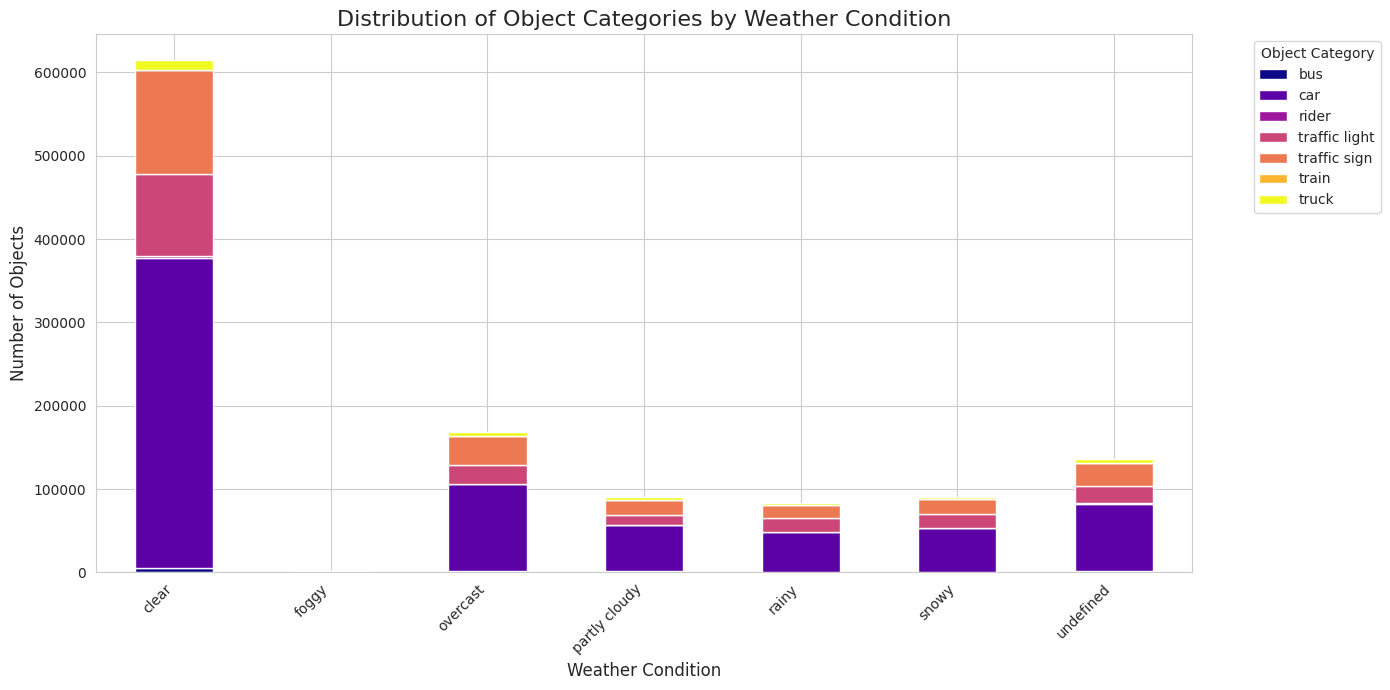


📈 Percentage distribution by weather:
category       bus   car  rider  traffic light  traffic sign  train  truck
weather                                                                   
clear         0.79 60.61   0.33          15.93         20.28   0.01   2.04
foggy         0.72 64.83   0.22          15.07         17.50   0.00   1.66
overcast      1.15 61.47   0.46          13.40         20.38   0.01   3.13
partly cloudy 1.20 61.91   0.40          12.48         20.47   0.02   3.52
rainy         1.12 57.45   0.24          19.26         19.31   0.01   2.62
snowy         1.10 57.23   0.22          18.44         20.05   0.02   2.94
undefined     1.38 58.97   0.69          15.66         20.28   0.00   3.03


In [31]:
print("🌤️ === ANALYSIS 2: WEATHER CONDITIONS vs OBJECTS ===")

# Group by weather and category
weather_counts = df_objects_filtered.groupby(['weather', 'category']).size().unstack(fill_value=0)
print("\n📊 Object counts by weather condition:")
print(weather_counts)

# Visualization: Stacked bar chart for weather
plt.figure(figsize=(14, 7))
weather_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='plasma')
plt.title('Distribution of Object Categories by Weather Condition', fontsize=16)
plt.ylabel('Number of Objects', fontsize=12)
plt.xlabel('Weather Condition', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Object Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate percentages for better understanding
weather_percentages = weather_counts.div(weather_counts.sum(axis=1), axis=0) * 100
print(f"\n📈 Percentage distribution by weather:")
print(weather_percentages.round(2))

🏙️ === ANALYSIS 3: SCENE TYPES vs OBJECTS ===

📊 Object counts by scene type:
category       bus     car  rider  traffic light  traffic sign  train  truck
scene                                                                       
city street   8729  448493   3809         156911        159035     82  20045
gas stations     0     189      0             25            38      0      7
highway       2237  158695    375          18912         62023     48   7588
parking lot     36    4592      4            185           542      0    109
residential    622   98101    322           9725         17490      6   2125
tunnel          15     684      3             39            87      0     35
undefined       33    2457      4            320           471      0     62


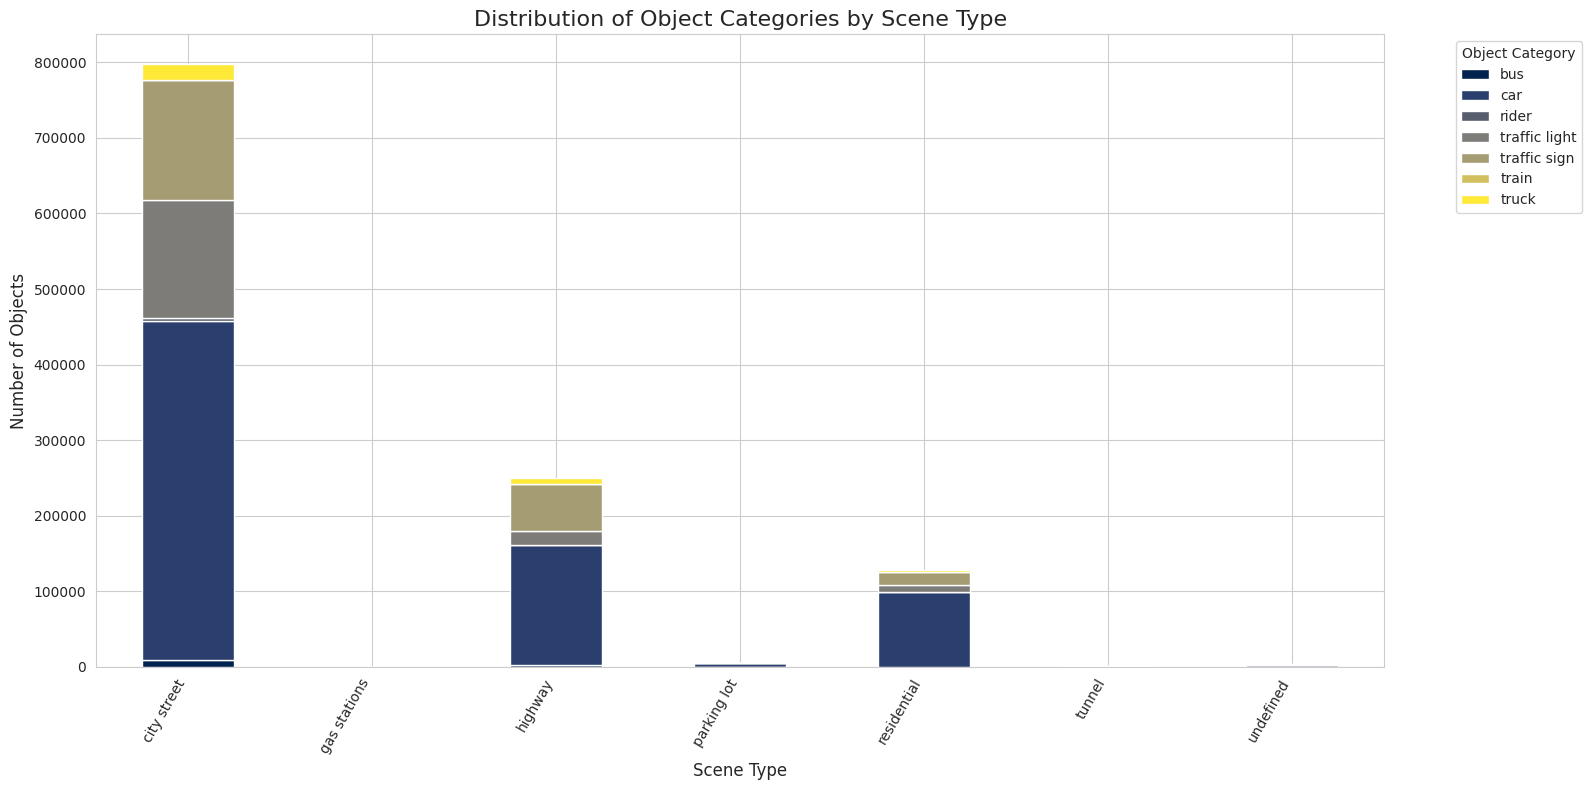


🎯 === FINAL KEY OBSERVATIONS & INSIGHTS ===

1. 🌅 TIME OF DAY OBSERVATIONS:
   • Data distribution: {'dawn/dusk': 89804, 'daytime': 657255, 'night': 437226, 'undefined': 1025}
   • The dataset is heavily skewed toward 'day' conditions
   • Night and dawn/dusk have significantly fewer annotations

2. 🌤️ WEATHER CONDITION OBSERVATIONS:
   • Data distribution: {'clear': 614933, 'foggy': 1811, 'overcast': 168901, 'partly cloudy': 90015, 'rainy': 82990, 'snowy': 91048, 'undefined': 135612}
   • Dataset is dominated by 'clear' weather conditions
   • Adverse weather (rain, fog) have very limited representation

3. 🏙️ SCENE TYPE OBSERVATIONS:
   • Top 5 scene types: {'city street': 797104, 'highway': 249878, 'residential': 128391, 'parking lot': 5468, 'undefined': 3347}
   • Urban environments (city street, residential) dominate
   • Highway/freeway scenes have fewer pedestrian/bicycle objects (as expected)

4. 🚨 IMPLICATIONS FOR MODEL TRAINING:
   • Model will likely perform best in: day, c

In [32]:
print("🏙️ === ANALYSIS 3: SCENE TYPES vs OBJECTS ===")

# Group by scene and category
scene_counts = df_objects_filtered.groupby(['scene', 'category']).size().unstack(fill_value=0)
print("\n📊 Object counts by scene type:")
print(scene_counts)

# Visualization: Scene types (might be busy, so let's handle it carefully)
plt.figure(figsize=(16, 8))
scene_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='cividis')
plt.title('Distribution of Object Categories by Scene Type', fontsize=16)
plt.ylabel('Number of Objects', fontsize=12)
plt.xlabel('Scene Type', fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.legend(title='Object Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🎯 === FINAL KEY OBSERVATIONS & INSIGHTS ===")
print("="*60)

print("\n1. 🌅 TIME OF DAY OBSERVATIONS:")
total_by_timeofday = df_objects_filtered.groupby('timeofday').size()
print(f"   • Data distribution: {dict(total_by_timeofday)}")
print("   • The dataset is heavily skewed toward 'day' conditions")
print("   • Night and dawn/dusk have significantly fewer annotations")
if 'night' in pedestrian_timeofday.index and pedestrian_timeofday['night'] < pedestrian_timeofday.get('day', 0):
    print("   • ✅ CONFIRMED: Pedestrians are underrepresented at night")

print("\n2. 🌤️ WEATHER CONDITION OBSERVATIONS:")
total_by_weather = df_objects_filtered.groupby('weather').size()
print(f"   • Data distribution: {dict(total_by_weather)}")
print("   • Dataset is dominated by 'clear' weather conditions")
print("   • Adverse weather (rain, fog) have very limited representation")

print("\n3. 🏙️ SCENE TYPE OBSERVATIONS:")
total_by_scene = df_objects_filtered.groupby('scene').size().sort_values(ascending=False)
print(f"   • Top 5 scene types: {dict(total_by_scene.head())}")
print("   • Urban environments (city street, residential) dominate")
print("   • Highway/freeway scenes have fewer pedestrian/bicycle objects (as expected)")

print("\n4. 🚨 IMPLICATIONS FOR MODEL TRAINING:")
print("   • Model will likely perform best in: day, clear weather, urban scenes")
print("   • Model may struggle with: night detection, adverse weather, rare scenes")
print("   • Consider data augmentation for underrepresented conditions")
print("   • Pay special attention to night-time pedestrian detection")

print(f"\n📋 SUMMARY STATISTICS:")
print(f"   • Total images analyzed: {len(bdd_data):,}")
print(f"   • Total object instances: {len(df_objects_filtered):,}")
print(f"   • Object categories: {len(df_objects_filtered['category'].unique())}")
print(f"   • Most common object: {df_objects_filtered['category'].value_counts().index[0]}")

## 5. Bounding Box Features

In [33]:
# compute aspect ratio and normalize
def compute_aspect_ratios_and_normalize(df_cleaned, img_width: int=1280, img_height: int=720):
    """
    Compute aspect ratios and normalize bounding boxes
    
    Parameters:
    df_cleaned: DataFrame with columns ['width', 'height', 'category', 'image'] and bbox coords
    img_width, img_height: Standard BDD100K image dimensions
    """
    df = df_cleaned.copy()
    
    # Handle potential division issues
    df = df[df['height'] > 0] 
    df = df[df['width'] > 0]   
    
    df['aspect_ratio'] = df['width'] / df['height']

    if all(col in df.columns for col in ['x1', 'y1', 'x2', 'y2']):
        df['norm_x1'] = df['x1'] / img_width
        df['norm_y1'] = df['y1'] / img_height
        df['norm_x2'] = df['x2'] / img_width
        df['norm_y2'] = df['y2'] / img_height
        df['norm_width'] = df['width'] / img_width
        df['norm_height'] = df['height'] / img_height
    else:
        # If no bbox coordinates, just normalize width/height
        df['norm_width'] = df['width'] / img_width
        df['norm_height'] = df['height'] / img_height
        
    df['norm_area'] = df['norm_width'] * df['norm_height']
    
    # Compute additional metrics
    df['bbox_area'] = df['width'] * df['height']
    df['log_aspect_ratio'] = np.log(df['aspect_ratio'])
    
    return df

In [34]:
df_enhanced = compute_aspect_ratios_and_normalize(df_cleaned)
df_enhanced.head()

,image,category,x1,y1,x2,y2,width,height,area,aspect_ratio,norm_x1,norm_y1,norm_x2,norm_y2,norm_width,norm_height,norm_area,bbox_area,log_aspect_ratio
0,0000f77c-6257be58.jpg,traffic light,1125.90,133.18,1156.98,210.88,31.08,77.69,2414.35,0.40,0.88,0.18,0.90,0.29,0.02,0.11,0.00,2414.35,-0.92
1,0000f77c-6257be58.jpg,traffic light,1156.98,136.64,1191.51,210.88,34.53,74.24,2563.39,0.47,0.90,0.19,0.93,0.29,0.03,0.10,0.00,2563.39,-0.77
2,0000f77c-6257be58.jpg,traffic sign,1101.73,211.12,1170.79,233.57,69.06,22.44,1549.96,3.08,0.86,0.29,0.91,0.32,0.05,0.03,0.00,1549.96,1.12
3,0000f77c-6257be58.jpg,traffic sign,0.00,0.25,100.38,122.83,100.38,122.58,12304.69,0.82,0.00,0.00,0.08,0.17,0.08,0.17,0.01,12304.69,-0.20
4,0000f77c-6257be58.jpg,car,45.24,254.53,357.81,487.91,312.56,233.38,72945.10,1.34,0.04,0.35,0.28,0.68,0.24,0.32,0.08,72945.10,0.29


In [35]:
def analyze_aspect_ratios_by_category(df):
    """
    Analyze aspect ratio distribution per category
    """
    print("ASPECT RATIO ANALYSIS BY CATEGORY")
    print("=" * 60)
    
    # Overall aspect ratio statistics
    print(f"\nOverall Aspect Ratio Statistics:")
    print(f"Mean: {df['aspect_ratio'].mean():.3f}")
    print(f"Median: {df['aspect_ratio'].median():.3f}")
    print(f"Std: {df['aspect_ratio'].std():.3f}")
    print(f"Min: {df['aspect_ratio'].min():.3f}")
    print(f"Max: {df['aspect_ratio'].max():.3f}")
    
    # Category-wise aspect ratio statistics
    print(f"\nCategory-wise Aspect Ratio Statistics:")
    category_stats = df.groupby('category')['aspect_ratio'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(3)
    category_stats = category_stats.sort_values('count', ascending=False)
    print(category_stats)
    
    # Identify categories with extreme aspect ratios
    print(f"\nCategories with Extreme Aspect Ratios:")
    for category in df['category'].unique():
        cat_data = df[df['category'] == category]['aspect_ratio']
        q1, q3 = cat_data.quantile([0.25, 0.75])
        iqr = q3 - q1
        outliers = cat_data[(cat_data < q1 - 1.5*iqr) | (cat_data > q3 + 1.5*iqr)]
        print(f"  {category}: {len(outliers)} outliers ({len(outliers)/len(cat_data)*100:.1f}%)")
    
    return category_stats


In [36]:
category_stats = analyze_aspect_ratios_by_category(df_enhanced)
category_stats

ASPECT RATIO ANALYSIS BY CATEGORY

Overall Aspect Ratio Statistics:
Mean: 1.215
Median: 1.100
Std: 0.761
Min: 0.028
Max: 117.027

Category-wise Aspect Ratio Statistics:
                count  mean  median  std  min    max
category                                            
car            713165  1.35    1.25 0.66 0.03 117.03
traffic sign   239674  1.50    1.17 0.99 0.03  48.81
traffic light  186098  0.71    0.61 0.40 0.03  51.00
person          91341  0.46    0.41 0.29 0.05  32.00
truck           29969  1.30    1.12 0.71 0.06  33.00
bus             11672  1.43    1.17 0.86 0.06  13.25
bike             7209  0.96    0.85 0.51 0.10  16.25
rider            4516  0.58    0.54 0.28 0.11  12.00
motor            3002  1.02    0.91 0.44 0.14   4.71
train             136  3.73    1.66 4.89 0.33  38.63

Categories with Extreme Aspect Ratios:
  traffic light: 4773 outliers (2.6%)
  traffic sign: 8529 outliers (3.6%)
  car: 37133 outliers (5.2%)
  person: 6248 outliers (6.8%)
  bus: 859 outliers 

,count,mean,median,std,min,max
category,,,,,,
car,713165,1.35,1.25,0.66,0.03,117.03
traffic sign,239674,1.50,1.17,0.99,0.03,48.81
traffic light,186098,0.71,0.61,0.40,0.03,51.00
person,91341,0.46,0.41,0.29,0.05,32.00
truck,29969,1.30,1.12,0.71,0.06,33.00
bus,11672,1.43,1.17,0.86,0.06,13.25
bike,7209,0.96,0.85,0.51,0.10,16.25
rider,4516,0.58,0.54,0.28,0.11,12.00
motor,3002,1.02,0.91,0.44,0.14,4.71


In [37]:
def plot_aspect_ratio_distributions(df, save_plots=True):
    """
    Create comprehensive aspect ratio distribution plots
    """
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Overall distribution
    plt.subplot(3, 3, 1)
    plt.hist(df['aspect_ratio'], bins=100, alpha=0.7, edgecolor='black', density=True)
    plt.axvline(df['aspect_ratio'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["aspect_ratio"].mean():.2f}')
    plt.axvline(df['aspect_ratio'].median(), color='orange', linestyle='--', 
                label=f'Median: {df["aspect_ratio"].median():.2f}')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Density')
    plt.title('Overall Aspect Ratio Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Log-scale distribution
    plt.subplot(3, 3, 2)
    plt.hist(df['aspect_ratio'], bins=100, alpha=0.7, edgecolor='black', density=True)
    plt.yscale('log')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Log Density')
    plt.title('Aspect Ratio Distribution (Log Scale)')
    plt.grid(True, alpha=0.3)
    
    # 3. Box plot by category
    plt.subplot(3, 3, 3)
    df_sorted = df.copy()
    category_order = df['category'].value_counts().index.tolist()
    sns.boxplot(data=df_sorted, y='category', x='aspect_ratio', order=category_order)
    plt.title('Aspect Ratio by Category')
    plt.xlabel('Aspect Ratio')
    
    # 4. Violin plot by category
    plt.subplot(3, 3, 4)
    sns.violinplot(data=df_sorted, y='category', x='aspect_ratio', order=category_order)
    plt.title('Aspect Ratio Distribution by Category')
    plt.xlabel('Aspect Ratio')
    
    # 5. Histogram by top categories
    plt.subplot(3, 3, 5)
    top_categories = df['category'].value_counts().head(5).index.tolist()
    for i, cat in enumerate(top_categories):
        cat_data = df[df['category'] == cat]['aspect_ratio']
        plt.hist(cat_data, bins=50, alpha=0.6, label=cat, density=True)
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Density')
    plt.title('Top 5 Categories - Aspect Ratio Distributions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Aspect ratio vs object size
    plt.subplot(3, 3, 6)
    plt.scatter(df['bbox_area'], df['aspect_ratio'], alpha=0.1, s=1)
    plt.xscale('log')
    plt.xlabel('Bounding Box Area (pixels²)')
    plt.ylabel('Aspect Ratio')
    plt.title('Aspect Ratio vs Object Size')
    plt.grid(True, alpha=0.3)
    
    # 7. Normalized width vs height scatter
    plt.subplot(3, 3, 7)
    plt.scatter(df['norm_width'], df['norm_height'], alpha=0.1, s=1, c=df['aspect_ratio'], cmap='viridis')
    plt.xlabel('Normalized Width')
    plt.ylabel('Normalized Height')
    plt.title('Normalized Width vs Height (colored by aspect ratio)')
    plt.colorbar(label='Aspect Ratio')
    plt.grid(True, alpha=0.3)
    
    # 8. Category-wise mean aspect ratios
    plt.subplot(3, 3, 8)
    cat_means = df.groupby('category')['aspect_ratio'].mean().sort_values(ascending=True)
    cat_means.plot(kind='barh')
    plt.xlabel('Mean Aspect Ratio')
    plt.title('Mean Aspect Ratio by Category')
    plt.grid(True, alpha=0.3)
    
    # 9. Cumulative distribution
    plt.subplot(3, 3, 9)
    for cat in top_categories:
        cat_data = df[df['category'] == cat]['aspect_ratio'].sort_values()
        plt.plot(cat_data.values, np.linspace(0, 1, len(cat_data)), label=cat, linewidth=2)
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution by Category')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('bdd100k_aspect_ratio_analysis.png', dpi=300, bbox_inches='tight')
        print("Aspect ratio analysis plot saved as 'bdd100k_aspect_ratio_analysis.png'")
    
    plt.show()

Aspect ratio analysis plot saved as 'bdd100k_aspect_ratio_analysis.png'


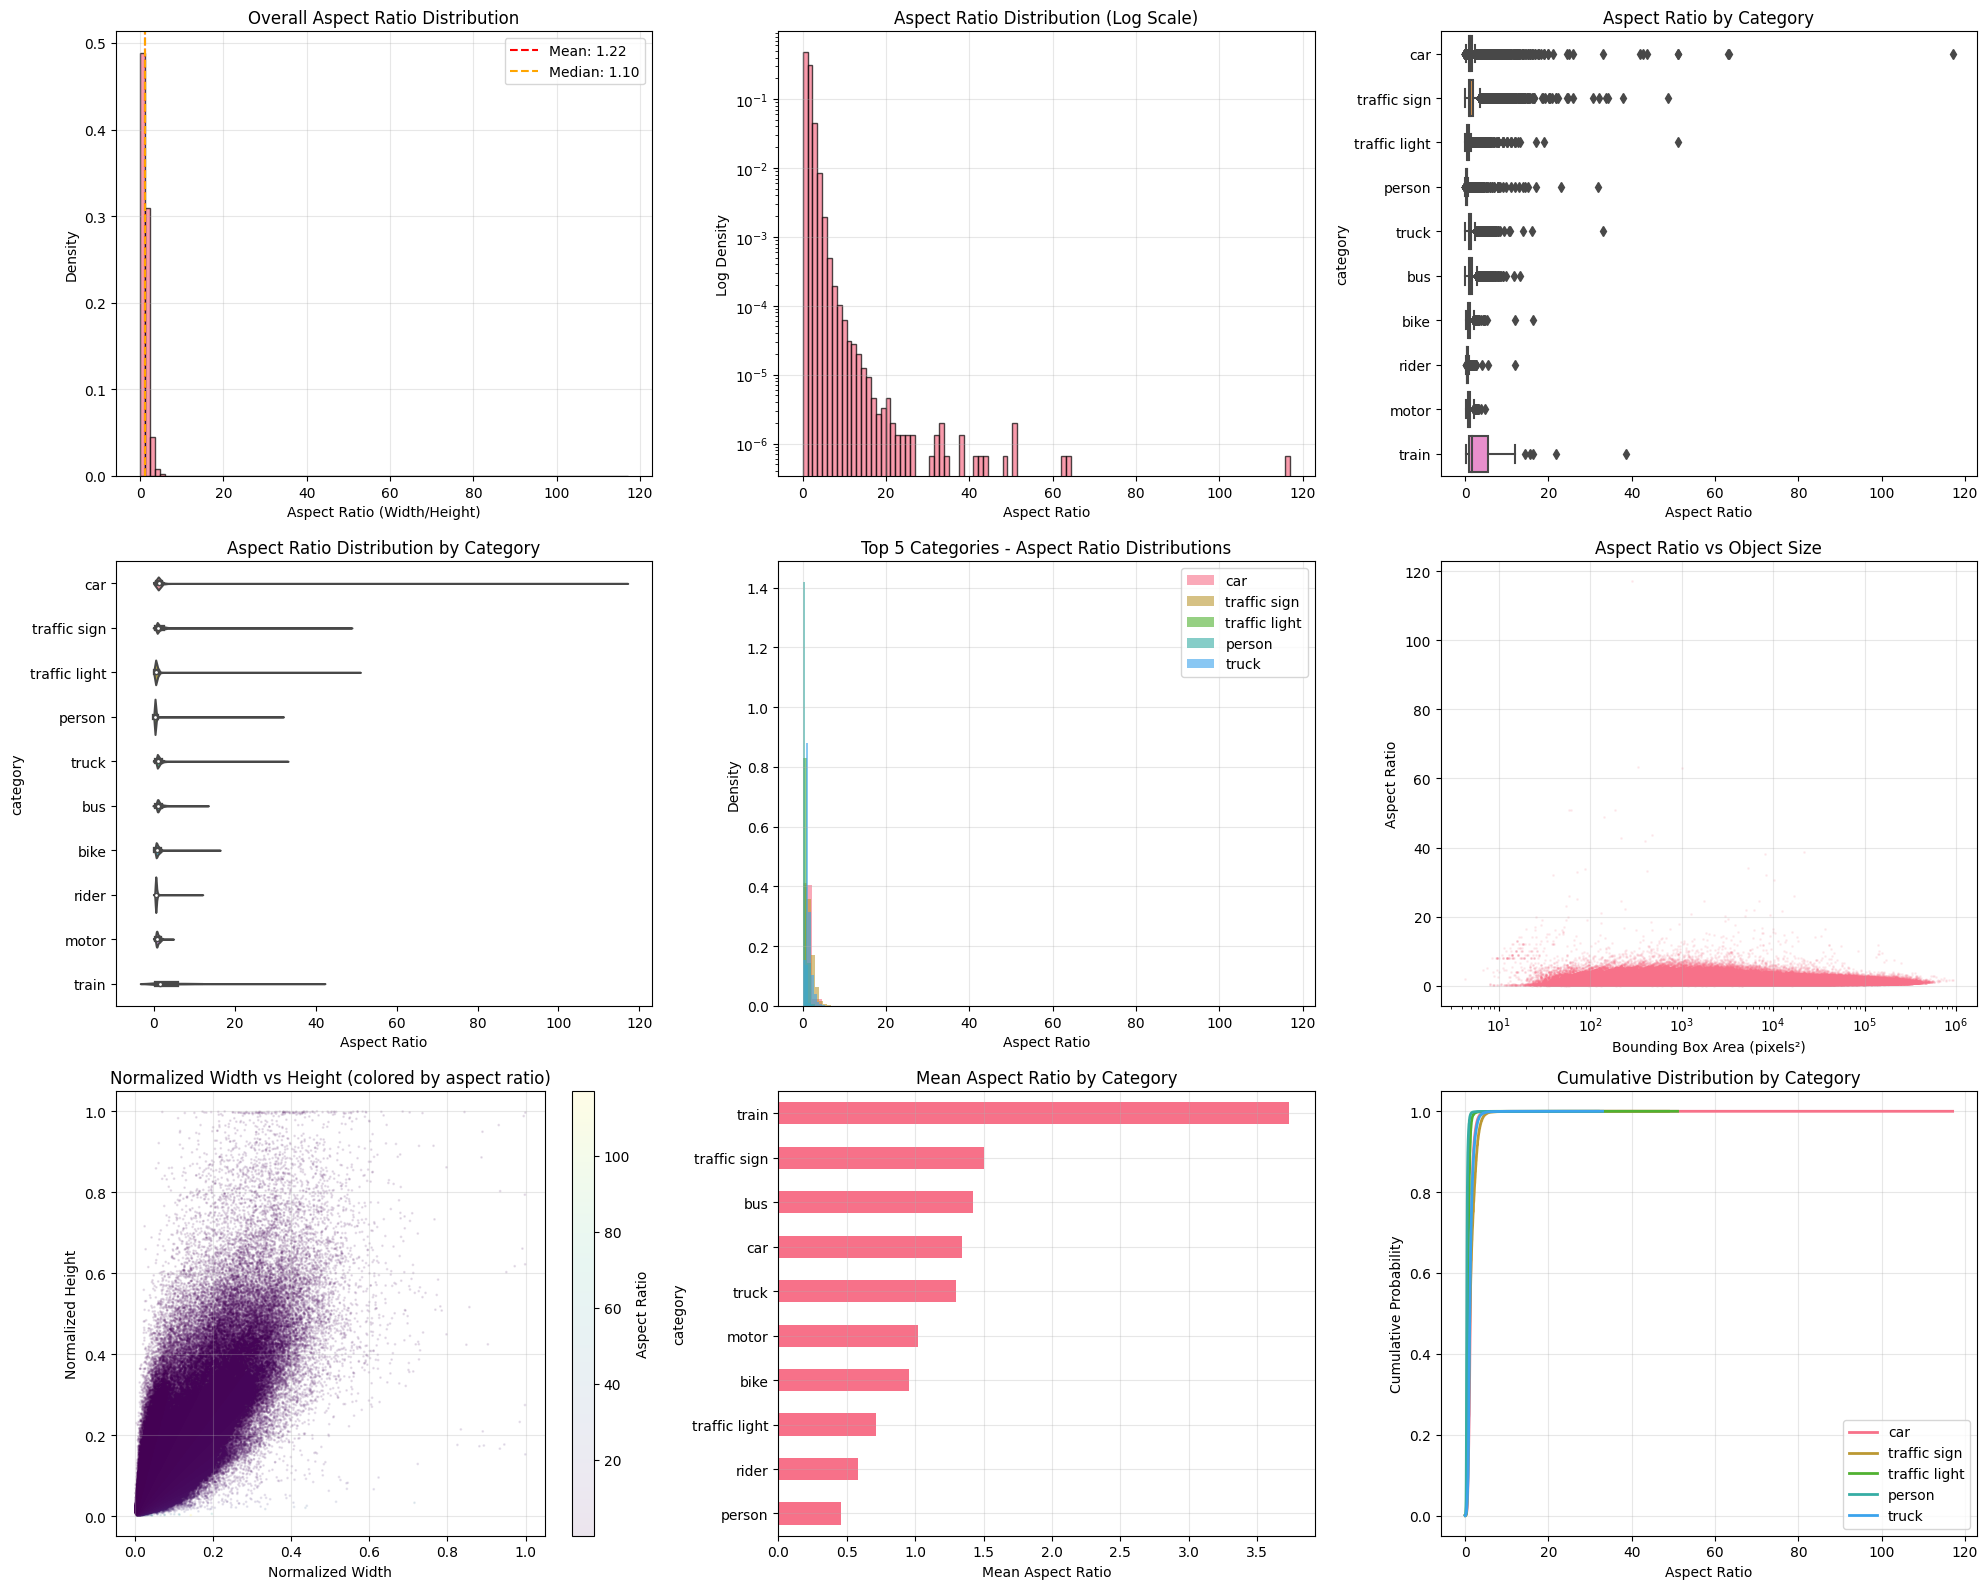

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

plot_aspect_ratio_distributions(df_enhanced)


In [39]:
def plot_normalization_analysis(df, save_plots=True):
    """
    Analyze normalized bounding box distributions
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Normalized width distribution
    axes[0, 0].hist(df['norm_width'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Normalized Width')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Normalized Width Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Normalized height distribution
    axes[0, 1].hist(df['norm_height'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Normalized Height')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Normalized Height Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Normalized area distribution
    axes[0, 2].hist(df['norm_area'], bins=50, alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('Normalized Area')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Normalized Area Distribution')
    axes[0, 2].set_xscale('log')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Box plots by category for normalized width
    top_cats = df['category'].value_counts().head(8).index
    df_top = df[df['category'].isin(top_cats)]
    sns.boxplot(data=df_top, x='category', y='norm_width', ax=axes[1, 0])
    axes[1, 0].set_title('Normalized Width by Category')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 5. Box plots by category for normalized height
    sns.boxplot(data=df_top, x='category', y='norm_height', ax=axes[1, 1])
    axes[1, 1].set_title('Normalized Height by Category')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 6. Aspect ratio vs normalized area by category
    for cat in top_cats[:5]:  # Top 5 categories
        cat_data = df[df['category'] == cat]
        axes[1, 2].scatter(cat_data['aspect_ratio'], cat_data['norm_area'], 
                          alpha=0.3, s=10, label=cat)
    axes[1, 2].set_xlabel('Aspect Ratio')
    axes[1, 2].set_ylabel('Normalized Area')
    axes[1, 2].set_title('Aspect Ratio vs Normalized Area by Category')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('bdd100k_normalization_analysis.png', dpi=300, bbox_inches='tight')
        print("Normalization analysis plot saved as 'bdd100k_normalization_analysis.png'")
    
    plt.show()

Normalization analysis plot saved as 'bdd100k_normalization_analysis.png'


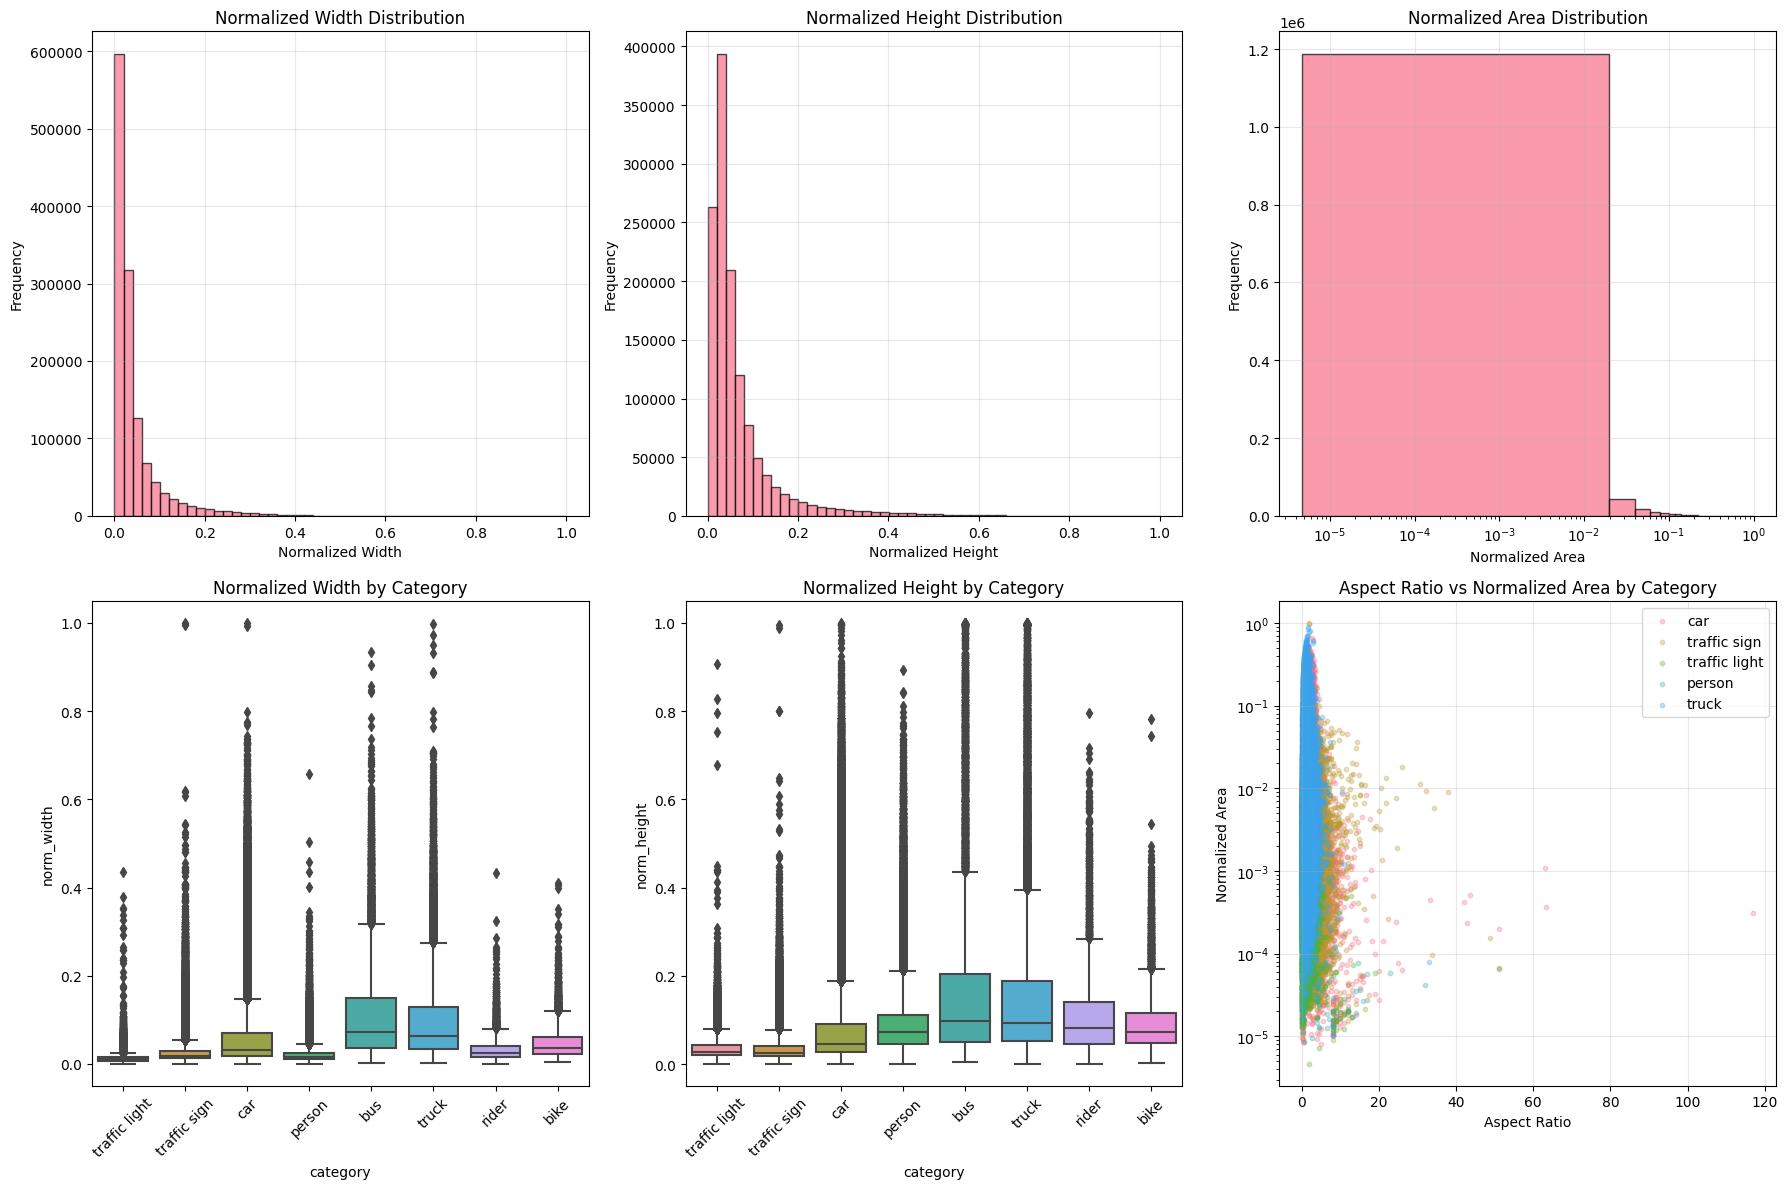

In [40]:
plot_normalization_analysis(df_enhanced)

## 6. Data Prep For Models

In [41]:
categories_1 = sorted(df_cleaned["category"].unique())
label_map = {cat: idx for idx, cat in enumerate(categories_1)}
print("Label map:", label_map)


Label map: {'bike': 0, 'bus': 1, 'car': 2, 'motor': 3, 'person': 4, 'rider': 5, 'traffic light': 6, 'traffic sign': 7, 'train': 8, 'truck': 9}


**Getting image dimensions correctly**

In [42]:
# def get_image_size(image_path):
#     img = cv2.imread(image_path)
#     if img is not None:
#         return img.shape[1], img.shape[0]  # width, height
#     return None, None

**creating YOLO-style .txt files for each image**

In [43]:
from PIL import Image
import os
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# -------------------------------
# Config
# -------------------------------
image_dirs = {
    "train": "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train",
    "val": "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/val",
    "test": "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test",
}

output_dir = "yolo_labels"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------
# Step 1: Prepare image list
# -------------------------------
# List of images that actually have annotations
images_needed = set(df_cleaned["image"].unique())

# Collect paths of all images recursively
print("🔹 Collecting all image paths...")
image_paths = []
for split_dir in image_dirs.values():
    for root, _, files in os.walk(split_dir):
        for f in files:
            if f.endswith(".jpg"):
                image_paths.append(os.path.join(root, f))

print(f"Total images found on disk: {len(image_paths)}")

# -------------------------------
# Step 2: Read image sizes in parallel
# -------------------------------
def get_image_size_safe(img_path):
    try:
        with Image.open(img_path) as img:
            return os.path.basename(img_path), img.width, img.height
    except:
        return os.path.basename(img_path), None, None

print("🔹 Reading image sizes...")
image_sizes = {}
with ThreadPoolExecutor(max_workers=16) as executor:
    for img_name, w, h in tqdm(executor.map(get_image_size_safe, image_paths), total=len(image_paths)):
        if w and h:
            image_sizes[img_name] = (w, h)

print(f"✅ Total images with valid sizes: {len(image_sizes)}")

# -------------------------------
# Step 3: Group annotations
# -------------------------------
grouped_annots = df_cleaned.groupby("image")

# -------------------------------
# Step 4: Export YOLO labels
# -------------------------------
print("🔹 Exporting YOLO labels...")
missing_count = 0
exported_count = 0

for img_name, annots in tqdm(grouped_annots, total=len(grouped_annots)):
    if img_name not in image_sizes:
        missing_count += 1
        continue

    w, h = image_sizes[img_name]
    lines = []

    for _, row in annots.iterrows():
        class_id = label_map[row["category"]]
        x_center = ((row["x1"] + row["x2"]) / 2) / w
        y_center = ((row["y1"] + row["y2"]) / 2) / h
        box_width = row["width"] / w
        box_height = row["height"] / h
        lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    # Write label file
    label_file = os.path.join(output_dir, img_name.replace(".jpg", ".txt"))
    with open(label_file, "w") as f:
        f.write("\n".join(lines))
    exported_count += 1

print(f"✅ Exported {exported_count} YOLO label files")
print(f"⚠️ Skipped {missing_count} images (not found or broken)")


🔹 Collecting all image paths...
Total images found on disk: 100000
🔹 Reading image sizes...


100%|██████████| 100000/100000 [00:44<00:00, 2254.21it/s]


✅ Total images with valid sizes: 100000
🔹 Exporting YOLO labels...


100%|██████████| 69863/69863 [01:16<00:00, 914.12it/s]

✅ Exported 69863 YOLO label files
⚠️ Skipped 0 images (not found or broken)


**Train/Val/Test Split**

In [44]:
from sklearn.model_selection import train_test_split

images = df_cleaned["image"].unique()
train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)


In [45]:
print(f"""Train: {len(train_imgs)},
Val: {len(val_imgs)},
Test: {len(test_imgs)}""")

Train: 48904,
Val: 10479,
Test: 10480


#  **Model Training & Validation**

## 1- Baseline Model Setup

**Install & Verify Ultralytics**

In [46]:
# Install the latest Ultralytics YOLO
%pip install ultralytics>=8.3.185

# Import and run checks
import ultralytics
ultralytics.checks()

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6411.4/8062.4 GB disk)


**Organize the dataset**

In [47]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# ------------------------
# Paths
# ------------------------
base_dir = "/kaggle/working/dataset"
for sub in ["images/train", "images/val", "images/test",
            "labels/train", "labels/val", "labels/test"]:
    os.makedirs(os.path.join(base_dir, sub), exist_ok=True)

image_dirs = {
    "train": "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/train",
    "val": "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/val",
    "test": "/kaggle/input/solesensei_bdd100k/bdd100k/bdd100k/images/100k/test",
}

# ------------------------
# Step 1: Build a dict of all images (filename -> full path)
# Recursively handle subfolders
# ------------------------
print("🔹 Collecting all image paths...")
image_index = {}
for split, folder in image_dirs.items():
    for root, _, files in os.walk(folder):
        for f in files:
            if f.endswith(".jpg"):
                # Only use filename for lookup
                image_index[f] = os.path.join(root, f)
print(f"✅ Total images found on disk: {len(image_index)}")

# ------------------------
# Step 2: Function to copy one image + label
# ------------------------
def copy_file(img_name, split):
    warnings = []
    # Copy image
    if img_name in image_index:
        src_img = image_index[img_name]
        dst_img = os.path.join(base_dir, f"images/{split}/{img_name}")
        try:
            shutil.copy(src_img, dst_img)
        except Exception as e:
            warnings.append(f"⚠️ Could not copy image {img_name}: {e}")
    else:
        warnings.append(f"⚠️ {img_name} not found for split {split}")

    # Copy label
    label_name = img_name.replace(".jpg", ".txt")
    src_lbl = os.path.join("yolo_labels", label_name)
    dst_lbl = os.path.join(base_dir, f"labels/{split}/{label_name}")
    if os.path.exists(src_lbl):
        try:
            shutil.copy(src_lbl, dst_lbl)
        except Exception as e:
            warnings.append(f"⚠️ Could not copy label {label_name}: {e}")
    else:
        warnings.append(f"⚠️ Missing label for {img_name}")

    return warnings

# ------------------------
# Step 3: Parallel copy with progress bar
# ------------------------
def move_files_parallel(img_list, split, max_workers=16):
    all_warnings = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for warnings in tqdm(executor.map(lambda img: copy_file(img, split),
                                          img_list),
                              total=len(img_list),
                              desc=f"Copying {split}"):
            all_warnings.extend(warnings)
    return all_warnings

# ------------------------
# Step 4: Apply splits
# Make sure your train_imgs, val_imgs, test_imgs are lists of filenames
# Example: train_imgs = df_train["image"].tolist()
# ------------------------
warnings_train = move_files_parallel(train_imgs, "train")
warnings_val = move_files_parallel(val_imgs, "val")
warnings_test = move_files_parallel(test_imgs, "test")

print("✅ All files copied!")
print(f"Total warnings: {len(warnings_train) + len(warnings_val) + len(warnings_test)}")


🔹 Collecting all image paths...
✅ Total images found on disk: 100000


Copying test: 100%|██████████| 10480/10480 [00:08<00:00, 1236.08it/s]

✅ All files copied!
Total warnings: 0


In [48]:
# ------------------------
# Step 5: Count final images with progress
# ------------------------
def count_images(folder):
    total = 0
    with os.scandir(folder) as entries:
        for entry in tqdm(entries, desc=f"Counting in {folder}", unit="files"):
            if entry.is_file() and entry.name.endswith(".jpg"):
                total += 1
    return total

train_count = count_images(os.path.join(base_dir, "images/train"))
val_count = count_images(os.path.join(base_dir, "images/val"))
test_count = count_images(os.path.join(base_dir, "images/test"))

print("\n📊 Final counts:")
print("Train images:", train_count)
print("Val images:", val_count)
print("Test images:", test_count)

Counting in /kaggle/working/dataset/images/train: 48904files [00:00, 1056063.94files/s]
Counting in /kaggle/working/dataset/images/val: 10479files [00:00, 1053249.74files/s]
Counting in /kaggle/working/dataset/images/test: 10480files [00:00, 1072078.87files/s]


📊 Final counts:
Train images: 48904
Val images: 10479
Test images: 10480


**Create `dataset.yaml`**

In [4]:
import random, shutil, os

def sample_subset(src_img, src_lbl, dst_img, dst_lbl, n=20000):
    os.makedirs(dst_img, exist_ok=True)
    os.makedirs(dst_lbl, exist_ok=True)
    
    images = [f for f in os.listdir(src_img) if f.endswith(".jpg")]
    sample = random.sample(images, min(len(images), n))
    
    for f in sample:
        # Copy image
        shutil.copy(os.path.join(src_img, f), os.path.join(dst_img, f))
        # Copy matching label
        label = f.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(src_lbl, label)):
            shutil.copy(os.path.join(src_lbl, label), os.path.join(dst_lbl, label))

# Example: 20k train, 5k val, 5k test
sample_subset("/kaggle/working/dataset/images/train", "/kaggle/working/dataset/labels/train",
              "/kaggle/working/dataset/images/train_subset", "/kaggle/working/dataset/labels/train_subset",
              n=25000)

sample_subset("/kaggle/working/dataset/images/val", "/kaggle/working/dataset/labels/val",
              "/kaggle/working/dataset/images/val_subset", "/kaggle/working/dataset/labels/val_subset",
              n=5000)

sample_subset("/kaggle/working/dataset/images/test", "/kaggle/working/dataset/labels/test",
              "/kaggle/working/dataset/images/test_subset", "/kaggle/working/dataset/labels/test_subset",
              n=5000)

In [5]:
# yaml_content = """
# train: /kaggle/working/dataset/images/train
# val: /kaggle/working/dataset/images/val
# test: /kaggle/working/dataset/images/test

# nc: 10  # adjust if your dataset has different number of classes
# names: [ 'car', 'bus', 'truck', 'bike', 'pedestrian', 'traffic light', 'sign', 'train', 'motorcycle', 'other' ]
# """

# with open("/kaggle/working/dataset/dataset.yaml", "w") as f:
#     f.write(yaml_content)

yaml_content = """
train: /kaggle/working/dataset/images/train_subset
val: /kaggle/working/dataset/images/val_subset
test: /kaggle/working/dataset/images/test_subset

nc: 10  
names: [ 'car', 'bus', 'truck', 'bike', 'pedestrian', 'traffic light', 'sign', 'train', 'motorcycle', 'other' ]
"""

with open("/kaggle/working/dataset/dataset.yaml", "w") as f:
    f.write(yaml_content)

print("✅ dataset.yaml updated to use subset!")


✅ dataset.yaml updated to use subset!


**Train Baseline YOLO11**

In [6]:
from ultralytics import YOLO

# Load pretrained YOLO11s model
model = YOLO("yolo11s.pt")  # or yolo11s.pt(small-version), yolo11l.pt(large-version) depending on resources

# Train
model.train(
    data="/kaggle/working/dataset/dataset.yaml",
    # epochs=10,       # start small for baseline
    # imgsz=640,
    # batch=16,
    # device=0
    epochs=10,       # start small, then scale up
    imgsz=640,      # smaller images = faster
    batch=8,        # reduce if you hit CUDA OOM
    device=0,
    workers=2,      # Kaggle sometimes crashes if workers >2
    cache=True      # speeds up by caching images
)

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       6331     116491       0.67      0.407      0.445       0.25
                   car        388        607      0.557      0.338      0.373      0.174
                   bus        820       1046      0.614      0.512       0.55      0.412
                 truck       6243      64554      0.735      0.688      0.738      0.456
                  bike        209        291      0.574      0.255      0.284      0.142
            pedestrian       1982       8196      0.677      0.472      0.539      0.265
         traffic light        313        386      0.605      0.309      0.357       0.18
                  sign       3545      16657      0.643      0.478      0.498      0.183
                 train       5184      22086      0.676      0.502      0.556      0.291
            motorcycle         14         18          1          0          0          0
                 other       1648       2650       0.62      0.514       0.56        0.4
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3ca9b66c50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

**Evaluate**

In [ ]:
# Validation
metrics = model.val()
print(metrics)
# Inference on test set
results = model.predict("/kaggle/working/dataset/images/test_subset", save=True, conf=0.25)

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,670 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1113.1±258.4 MB/s, size: 54.4 KB)
val: Scanning /kaggle/working/dataset/labels/val_subset.cache... 6331 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6331/6331 10.8Mit/s 0.0s
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (4.1GB RAM): 100% ━━━━━━━━━━━━ 6331/6331 552.0it/s 11.5s<0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 792/792 14.0it/s 56.7s<0.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       6331     116491       0.67      0.407      0.446      0.251
                   car        388        607      0.556      0.338      0.375      0.175
                   bus        820       1046      0.612      0.512       0.55      0.412
                 truck       6243      64554      0.735      0.688      0.738      0.457
                  bike        209        291      0.578      0.259      0.284      0.143
            pedestrian       1982       8196      0.677      0.472       0.54      0.266
         traffic light        313        386      0.601      0.309      0.356      0.181
                  sign       3545      16657      0.645      0.479      0.499      0.184
                 train       5184      22086      0.675      0.502      0.556      0.292
            motorcycle         14         18          1          0          0          0
                 other       1648       2650      0.619      0.514       0.56      0.401
Speed: 0.2ms preproce

In [1]:
import shutil, os

src = "/kaggle/working/runs/detect/train/weights/best.pt"
dst = "/kaggle/working/models/best.pt"

os.makedirs("/kaggle/working/models", exist_ok=True)
shutil.copy(src, dst)

print("Model copied to:", dst)

Model copied to: /kaggle/working/models/best.pt


In [3]:
from IPython.display import FileLink
FileLink("/kaggle/working/models/best.pt")

/kaggle/working/models/best.pt